In [20]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [27]:
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100)     
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None) 


# Text Preprocessing

In [21]:

df = pd.read_csv('08_stemmed.csv')
df1 = pd.read_csv('2700_stemmed.csv')
df = pd.concat([df, df1])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8344 entries, 0 to 2781
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      8344 non-null   int64  
 1   created_at               8344 non-null   object 
 2   favorite_count           8344 non-null   int64  
 3   full_text                8344 non-null   object 
 4   id_str                   8344 non-null   int64  
 5   image_url                2141 non-null   object 
 6   in_reply_to_screen_name  4202 non-null   object 
 7   lang                     8344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              8344 non-null   int64  
 10  reply_count              8344 non-null   int64  
 11  retweet_count            8344 non-null   int64  
 12  tweet_url                8344 non-null   object 
 13  user_id_str              8344 non-null   int64  
 14  username                 2782

In [39]:
df.duplicated().sum()

0

In [40]:
df['label'].value_counts()

label
positif    3856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64

In [ ]:
df_negatif = df[df['label'] == 'positif']
df_lainnya = df[df['label'] != 'positif']

df_negatif_tersisa = df_negatif.sample(n=len(df_negatif) - 1000, random_state=42)

df = pd.concat([df_negatif_tersisa, df_lainnya], ignore_index=True)

print(df['label'].value_counts())


label
positif    2856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64


In [ ]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

mention_whitelist = ['prabowo']

normalisasi_kata = {
    'gak': 'tidak',
    'ga': 'tidak',
    'yg': 'yang',
    'utk': 'untuk',
    'dgn': 'dengan',
    'apik': 'baik',
    'sdh': 'sudah',
    'krn': 'karena',
    'apik': 'bagus',
    'tdk': 'tidak',
    'klo': 'kalo',
    'sbg': 'sebagai',
    'gue': 'aku',
    'dlm': 'dalam',
    'jgn': 'jangan',
    'jkw': 'jokowi',
    'org': 'orang',
    'nggak': 'tidak',
    'aja': '',
    'amp': '',
    'nya': '',
    'ya': '',
    'gitu': '',
    'loh': '',
    'dong': '',
    'sih': '',
    'deh': '',
    'nih': '',
    'kok': '',
}

def preprocessing(text):
    text = re.sub(r'@(\w+)', lambda m: m.group() if m.group(1).lower() in mention_whitelist else '', text)

    text = re.sub(r'http\S+|www\S+|<.*?>|#', ' ', text)
    
    text = re.sub(r'<.*?>', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    text = text.lower()

    tokens = word_tokenize(text)

    tokens = [normalisasi_kata.get(word, word) for word in tokens]

    tokens = [word for word in tokens if word not in stop_words and len(word) > 2 and word != '']

    tokens = [stemmer.stem(word) for word in tokens]
    
    return ' '.join(tokens)


In [ ]:
def apply_with_progress(df, func, column, new_column, step=50):
    result = []
    for i, text in enumerate(df[column]):
        result.append(func(text))
        if (i + 1) % step == 0 or (i + 1) == len(df):
            print(f"Processed {i + 1}/{len(df)} rows")
    df[new_column] = result
    return df

df = apply_with_progress(df, preprocessing, 'full_text', 'text_processed')
df.head()


Processed 50/7344 rows
Processed 100/7344 rows
Processed 150/7344 rows


KeyboardInterrupt: 

In [ ]:
from collections import Counter
import re

df_copy = df.copy()

text = ' '.join(df_copy['text_processed'].astype(str))

words = re.findall(r'\b\w+\b', text.lower())

freq = Counter(words)

top_50 = freq.most_common(150)

for word, count in top_50:
    print(f"{word}: {count}")



KeyboardInterrupt



In [28]:
df[df['label'] == 'campur']

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,text_processed1
3191,1909017807389679969,Sun Apr 06 23:09:33 +0000 2025,0,@_arhakim27 Menurut analisis kinerja Prabowo-Gibran sejak Oktober 2024 hingga kini bercampur. Pertumbuhan ekonomi stabil di 5% di bawah target 8% tapi program makan gratis jadi sorotan positif meski ada kekhawatiran soal perencanaan dan keberlanjutan. Publik puas (72 5% di 100 hari,1909020682937065661,NaN,_arhakim27,in,NaN,0,0,0,https://x.com/undefined/status/1909020682937065661,1720665183188922368,NaN,campur,analisis kerja prabowo gibran oktober campur tumbuh ekonomi stabil target program makan gratis sorot positif khawatir rencana lanjut publik puas


In [34]:
df = df.rename(columns={'text_processed1': 'text_processed'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      7344 non-null   int64  
 1   created_at               7344 non-null   object 
 2   favorite_count           7344 non-null   int64  
 3   full_text                7344 non-null   object 
 4   id_str                   7344 non-null   int64  
 5   image_url                1884 non-null   object 
 6   in_reply_to_screen_name  3803 non-null   object 
 7   lang                     7344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              7344 non-null   int64  
 10  reply_count              7344 non-null   int64  
 11  retweet_count            7344 non-null   int64  
 12  tweet_url                7344 non-null   object 
 13  user_id_str              7344 non-null   int64  
 14  username                

In [30]:
df.loc[df['label'] == 'campur', 'label'] = 'positif'


In [ ]:
import pandas as pd

df['label_num'] = df['label'].replace({'netral' : 0, 'positif' : 1, 'negatif' : 2})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      7344 non-null   int64  
 1   created_at               7344 non-null   object 
 2   favorite_count           7344 non-null   int64  
 3   full_text                7344 non-null   object 
 4   id_str                   7344 non-null   int64  
 5   image_url                1884 non-null   object 
 6   in_reply_to_screen_name  3803 non-null   object 
 7   lang                     7344 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              7344 non-null   int64  
 10  reply_count              7344 non-null   int64  
 11  retweet_count            7344 non-null   int64  
 12  tweet_url                7344 non-null   object 
 13  user_id_str              7344 non-null   int64  
 14  username                

In [32]:
df['label_num'].value_counts()

label_num
1    2857
2    2843
0    1644
Name: count, dtype: int64

In [35]:
df = df.dropna(subset=['text_processed'])

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = total_kata_unik
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 8794
MAX_WORDS yang digunakan: 8794


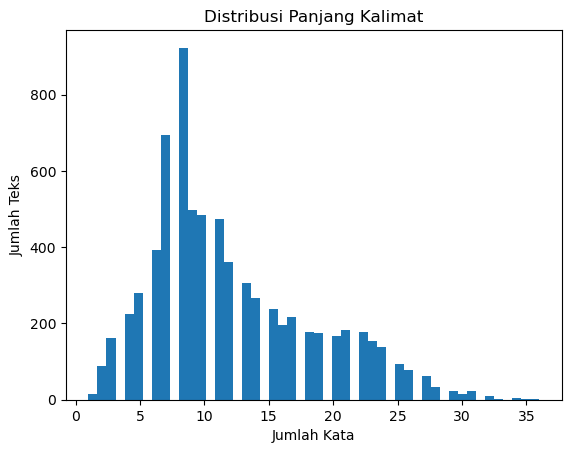

MAX_LEN (persentil 95): 36


In [ ]:
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 100))
print("panjang max kalimat:", MAX_LEN)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_processed'])
sequences = tokenizer.texts_to_sequences(df['text_processed'])

padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [39]:
df['label_num'].value_counts()

label_num
1    2857
2    2843
0    1642
Name: count, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 1    2000
 2    1990
 0    1149
 Name: count, dtype: int64,
 label_num
 1    857
 2    853
 0    493
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [41]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([1149, 2000, 1990], dtype=int64))


In [42]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.4908616187989556, 1: 0.8565, 2: 0.8608040201005025}

In [ ]:
import numpy as np
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', limit=50000)  # optional limit

embedding_dim = 300
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # fallback


In [44]:
# 1

from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.metrics import Recall, Precision
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model = Sequential()
model.add(Embedding(
    input_dim=MAX_WORDS,
    output_dim=embedding_dim,
    input_length=MAX_LEN,
    weights=[embedding_matrix],
    trainable=True
))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.1))))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='models/best_model_BILSTM.h5',         
    monitor='val_loss',               
    save_best_only=True,             
    mode='min',                      
    verbose=1                       
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  
    restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights  
)

Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 18.3419 - accuracy: 0.6877
Epoch 1: val_loss improved from inf to 2.23142, saving model to models\best_model_BILSTM.h5
161/161 [==============================] - 47s 158ms/step - loss: 18.3419 - accuracy: 0.6877 - val_loss: 2.2314 - val_accuracy: 0.6468 - lr: 0.0010
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 1.0433 - accuracy: 0.8116
Epoch 2: val_loss improved from 2.23142 to 1.09257, saving model to models\best_model_BILSTM.h5
161/161 [==============================] - 22s 137ms/step - loss: 1.0433 - accuracy: 0.8116 - val_loss: 1.0926 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.8445
Epoch 3: val_loss improved from 1.09257 to 0.66469, saving model to models\best_model_BILSTM.h5
161/161 [==============================] - 22s 136ms/step - loss: 0.6265 - accuracy: 0.8445 - val_loss: 0.6647 - val_accuracy: 0.

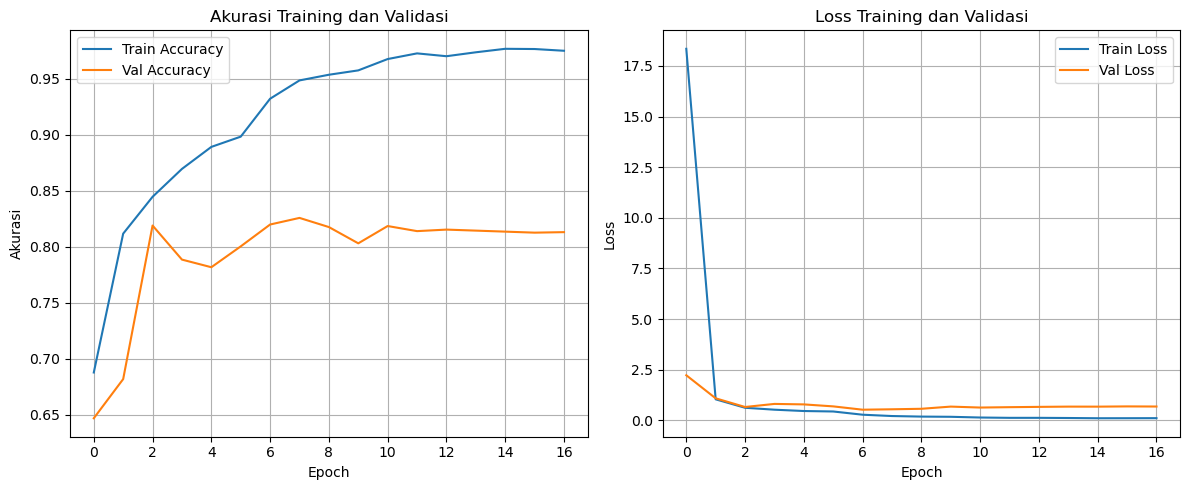

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


69/69 [==============================] - 7s 32ms/step


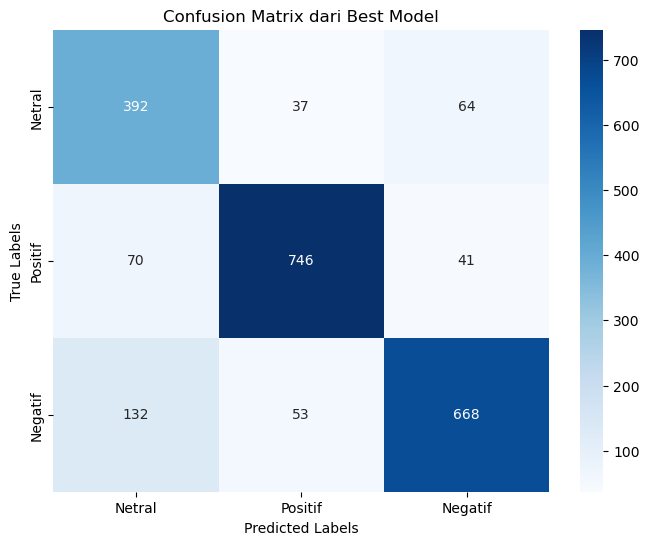

              precision    recall  f1-score   support

      Netral       0.66      0.80      0.72       493
     Positif       0.89      0.87      0.88       857
     Negatif       0.86      0.78      0.82       853

    accuracy                           0.82      2203
   macro avg       0.81      0.82      0.81      2203
weighted avg       0.83      0.82      0.82      2203



In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model = load_model("models/best_model_BILSTM.h5")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari Best Model')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
label_map = {0: "Netral", 1: "Positif", 2: "Negatif"}

def predict_text(text):
    clean_text = preprocessing(text)
    sequence = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    prediction = best_model.predict(padded)
    predicted_class = np.argmax(prediction)
    
    print(f"Teks: {text}")
    print(f"Prediksi Kelas: {predicted_class} → {label_map[predicted_class]}")

text = 'prabowo sekarang telah dilantik'
predict_text(text)